## Required Module Imports

### Both reading and writing APIs are contained within the **czi** object in pylibCZIrw, so let's start by importing it.

### Additional modules are imported alongside the **pylibCZIrw** package.

In [10]:
from pylibCZIrw import czi as pyczi
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os, sys
import glob
from tqdm import tqdm
from tqdm.contrib import itertools as it
from matplotlib.patches import Rectangle
import cv2
from scipy.ndimage import distance_transform_edt
from scipy.stats import mode

from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D
from cztile.tiling_strategy import Rectangle as czrect

# show the used python env
print("Using:", sys.executable)

Using: /mnt/hd1/ani/conda/bin/python


## Opening a CZI - read only!

##### A CZI file can be opened in a context manager using a path-like-object (in this case, file_path) with czi.open_czi(file_path) as czi: this will open the CZI in read-only mode.

##### Open a CZI and read metadata. We can open a czi using a context manager and then read the full metadata either as a raw XML string or as a dictionary

In [11]:
# Folder where all WSI ".czi" files exist
dir_rawfiles = "/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/"

# Folder where we want to save all extracted tiles
dir_imgs = "/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides_converted_svs/"

# Get list of all patient WSIs
wsi_img_list = (glob.glob(dir_rawfiles + "*.czi"))
wsi_img_list

['/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 26.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 27.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 31.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 01.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 29.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 25.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 30.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 03.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 35.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 43.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 11.czi',
 '/mnt/hd1/ani/Liver_pathology_project/Raw_data/Anh_slides/20230529__Ani 22.czi',
 '/mnt/hd1/ani/L

In [12]:
# open the CZI for reading
with pyczi.open_czi(wsi_img_list[2]) as czidoc:
    
    # get the raw metadata as a dictionary
    md_dict = czidoc.metadata
    
    # show some parts of it
    print(json.dumps(md_dict["ImageDocument"]["Metadata"]["Information"]["Image"], sort_keys=False, indent=4))

{
    "AcquisitionDateAndTime": "2023-05-30T09:59:09.3265289Z",
    "SizeC": "1",
    "ComponentBitCount": "8",
    "PixelType": "Bgr24",
    "SizeX": "18889",
    "SizeY": "68133",
    "SizeS": "3",
    "SizeB": "1",
    "SizeM": "245",
    "OriginalCompressionMethod": "JpgXr",
    "OriginalEncodingQuality": "85",
    "AcquisitionDuration": "138279.41280000002",
    "Dimensions": {
        "Channels": {
            "Channel": {
                "@Id": "Channel:0",
                "@Name": "TL Brightfield",
                "Color": "#FFFFFFFF",
                "Fluor": "TL Brightfield",
                "ExposureTime": "200000",
                "IlluminationType": "Transmitted",
                "ContrastMethod": "Brightfield",
                "PixelType": "Bgr24",
                "ComponentBitCount": "8",
                "AcquisitionMode": "WideField",
                "DetectorSettings": {
                    "Binning": "1,1",
                    "EMGain": "0",
                    "Detec

## Get image dimensions

##### There are different properties that allow us to retrieve information about dimensions. The total_bounding_box gives us all the dimensions of all orthogonal planes of the CZI image file.

In [13]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:

    # get the image dimensions as an dictionary, where the key identifies the dimension
    total_bounding_box = czidoc.total_bounding_box

print(total_bounding_box)

{'T': (0, 1), 'Z': (0, 1), 'C': (0, 1), 'B': (0, 1), 'X': (-171360, -152471), 'Y': (22680, 90904)}


##### The total_bounding_rectangle gives us the X and Y dimensions of the CZI, i.e. the (X, Y) of the total_bounding_box.

In [14]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:

    # get the total bounding box for all scenes
    total_bounding_rectangle = czidoc.total_bounding_rectangle

print(total_bounding_rectangle)

Rectangle(x=-171360, y=22680, w=18889, h=68224)


##### Scenes are not orthogonal to the other dimensions. They are contained within the 2D planes and can be seen simply as tags for certain regions.
The scene_bounding_rectangle give us the bounding rectangle for each scene.

In [15]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:

    # get the bounding boxes for each individual scene
    scenes_bounding_rectangle = czidoc.scenes_bounding_rectangle

print(scenes_bounding_rectangle)   



{0: Rectangle(x=-159841, y=29160, w=7370, h=21728), 1: Rectangle(x=-171360, y=22680, w=11776, h=68224), 2: Rectangle(x=-164160, y=51836, w=7371, h=22820)}


## Get the pixel type
A channel's pixel type can be discovered with using: get_channel_pixel_type

In [16]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:
    
    # get the pixel type for the 1st channel
    c0_pixel_type = czidoc.get_channel_pixel_type(0)

print(c0_pixel_type)

Bgr24


##### Or we can simply get all pixel types using: pixel_types

In [17]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:
    
    # get all pixel types as a dictionary, where the key is the channel index
    pixel_type = czidoc.pixel_types

print(pixel_type)

{0: 'Bgr24'}


## Read pixel data
Pixel data is read and returned as a numpy arry. The shape of the returned array and its data type will depend on the specified pixel_type.

BGR pixel type -> [y, x, 3]
Gray pixel type -> [y, x, 1]
The background_pixel determines the pixel value for the background (i.e. regions where no pixel data exists), and must be consistent with the pixel_type

pixel_type	background_pixel type	Default value
BGR	3-value tuple	(0, 0, 0)
Gray	Scalar value bounded by the gray scale	0
Read whole 2D plane
In order to read pixel data from a CZI image file it is important to understand the concept of "planewise reading".

Reading data planewise means that every read operation yields a 2D array with the shape (Y, X, 1) or (Y, X, 3) depending on the requested pixel type. We can specify which 2D plane to read using the plane argument (dictionary).

plane = {'C': 0, 'Z': 2, 'T': 1} - this will read a 2D plane from C=0, Z=2 and T=1
if plane is not specified at all the default is to use the 1st index for all dimensions
In order to read a complete Z-Stack, one would have to read each of the Z-slices using the plane argument. This can be easily created by "wrapping" those calls into some utility functions. To get started let's read a complete 2D plane.

Array Shape:  (68224, 18889, 3)


Text(0.5, 1.0, 'Frame_1')

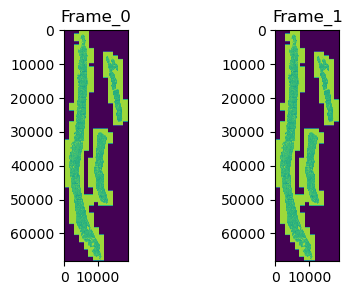

In [18]:
with pyczi.open_czi(wsi_img_list[2]) as czidoc:

    # define some plane coordinates
    plane_1 = {'C': 0}

    # equivalent to reading {'C': 0}
    frame_0 = czidoc.read()

    # get the shape of the 2d plane - the last dime indicates the pixel type
    # 3 = BGR and 1 = Gray
    print("Array Shape: ", frame_0.shape)

    # get specific planes 
    frame_1 = czidoc.read(plane=plane_1)

fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].imshow(frame_0[...,0])
ax[0].set_title("Frame_0")
ax[1].imshow(frame_1[...,0])
ax[1].set_title("Frame_1")

## Tiling or patch generation

In [205]:
# create a "tile" by specifying the desired tile dimension and the
# minimum required overlap between tiles (depends on the processing)
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(total_tile_width=4096,
                                                  total_tile_height=4096,
                                                  min_border_width=0)

# create CZI instance to read some metadata 
with pyczi.open_czi(wsi_img_list[2]) as czidoc_r:
    
    # get the bounding boxes for each individual scene: this will be a dictionary with keys = scene indices, values = [x,y,w,h] for that scene
    scenes_bounding_rectangle = czidoc_r.scenes_bounding_rectangle

    for i in range(len(scenes_bounding_rectangle)):

        # Read entire scene as an array
        scene_arr = czidoc_r.read(roi=scenes_bounding_rectangle[i], scene=i, zoom=1.0)
        scene_arr = scene_arr[:, :, ::-1]   # BGR --> RGB
        # scene_arr_mod_bkgrd = czidoc_r.read(roi=scenes_bounding_rectangle[i], scene=i, zoom=1.0, background_pixel=(203/255, 200/255, 216/255))
        # scene_arr_mod_bkgrd = scene_arr_mod_bkgrd[:, :, ::-1]   # BGR --> RGB

        # get the size of the bounding rectange for the scenes
        tiles = tiler.tile_rectangle(czidoc_r.scenes_bounding_rectangle[i])   # first scene

        for f, tile in enumerate(tiles):

            roi_x, roi_y, roi_w, roi_h = tile.roi.x, tile.roi.y, tile.roi.w, tile.roi.h            
            patch_4k = scene_arr[roi_y-np.abs(scenes_bounding_rectangle[i][1]):roi_y-np.abs(scenes_bounding_rectangle[i][1])+roi_h, roi_x+np.abs(scenes_bounding_rectangle[i][0]):roi_x+np.abs(scenes_bounding_rectangle[i][0])+roi_w, :]
            # print(patch_4k.shape)

            # if (i == 1) & (f >= 0) & (f < 5):
            
            ### Algorithm for matching black (no data) pixels with true background
            # Compute distance + feature transform
            # Output is a tuple with distance and feature matrices as 1st and 2nd elements respectively
            patch_4k_cp1, patch_4k_cp2 = patch_4k.copy(), patch_4k.copy()
                
            # Computing distance+feature transform
            edt = distance_transform_edt(patch_4k, return_indices=True)
            _, feat_transform = edt[0], edt[1]

            patch_4k_cp2[feat_transform[0], feat_transform[1], feat_transform[2]] = np.transpose(patch_4k_cp1, axes=(1,0,2))
            
            # Finding indices of pixels which are still be black
            inds = np.where((patch_4k_cp2[feat_transform[0], feat_transform[1], feat_transform[2]] == 0))   

            # Thresholding to isolate "true background" pixels
            img_gray = cv2.cvtColor(patch_4k, cv2.COLOR_RGB2GRAY)
            img_gray = img_gray.astype('uint8')
            t, img_thresh = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY)

            # Filter out tissue regions: we only want true background (=1)
            img_thresh[img_gray < 180] = 0

            # Extending to 3d stack
            img_thresh_stack = np.repeat(img_thresh, repeats=patch_4k.shape[2], axis=1)
            img_thresh_stack = img_thresh_stack.reshape((patch_4k.shape[0], patch_4k.shape[1], patch_4k.shape[2]))
                
            # Multiplying patch * thresholded mask to obtain true background
            patch_true_bkgrd = patch_4k * img_thresh_stack

            # plt.figure(figsize=(10,5))
            # plt.subplot(121)
            # plt.imshow(patch_4k)
            # plt.subplot(122)
            # plt.imshow(patch_true_bkgrd)

            patch_4k_cp2[inds[1], inds[0], 0], patch_4k_cp2[inds[1], inds[0], 1], patch_4k_cp2[inds[1], inds[0], 2] = patch_true_bkgrd[:,:,0].sum()/img_thresh_stack[:,:,0].sum(), patch_true_bkgrd[:,:,1].sum()/img_thresh_stack[:,:,1].sum(), patch_true_bkgrd[:,:,2].sum()/img_thresh_stack[:,:,2].sum()

            # # Lets visualize the result
            # plt.figure(figsize=(10,5))
            # plt.subplot(121)
            # plt.imshow(patch_4k)
            # plt.subplot(122)
            # plt.imshow(patch_4k_cp2)

            # plt.imsave(f"/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/Background_processing/sc_{i}_patch_{f}_pre.png", patch_4k)
            # plt.imsave(f"/mnt/hd1/ani/Liver_pathology_project/Prepared_datasets/Tile_size_4096x4096/Anh_slides/Background_processing/sc_{i}_patch_{f}_post.png", patch_4k_cp2)

/tmp/ipykernel_96711/1757036386.py:64: RuntimeWarning: invalid value encountered in ulong_scalars
  patch_4k_cp2[inds[1], inds[0], 0], patch_4k_cp2[inds[1], inds[0], 1], patch_4k_cp2[inds[1], inds[0], 2] = patch_true_bkgrd[:,:,0].sum()/img_thresh_stack[:,:,0].sum(), patch_true_bkgrd[:,:,1].sum()/img_thresh_stack[:,:,1].sum(), patch_true_bkgrd[:,:,2].sum()/img_thresh_stack[:,:,2].sum()
